In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## Initialization

In [5]:
#candidates arranged from most to least number of votes
candidates = np.load('2019_candidates.npy')

In [6]:
#senator votes arranged from highest to lowest overall
vote_data = pd.read_csv('senators_2019.csv',header=None).values

## Get overall cumulative distribution of votes for each candidate

In [7]:
def cum_distribution():
    cum_votes = []

    for i in range(len(candidates)):
        #get histogram of votes with 60 bins
        freq = np.histogram(vote_data.T[i],bins=60,range=[0,1])[0]
        
        #cumulative votes
        cum_vals = np.cumsum(freq)
        
        #normalize
        cum_votes.append(cum_vals/np.max(cum_vals))

    cum_votes = np.array(cum_votes)
    
    return cum_votes

In [8]:
cum_votes = cum_distribution()

/usr/local/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


## Perform PCA on cumulative distribution

In [9]:
cumulative_EV = [] #cumulative explained variance
dimensions = [] 
explained_var = [] #explained variance per dimension

max_components = 20

for i in range(max_components):
    #perform PCA using scikit function
    pca = PCA(n_components = i+1,svd_solver='full') #calculate covariance matrix
    y = pca.fit(cum_votes)
    
    explained_variance_ratio = y.explained_variance_ratio_
    explained_var.append(explained_variance_ratio[-1]*100)
    cumulative_EV.append(sum(explained_variance_ratio)*100)
    dimensions.append(i+1)

### Apply elbow method to PCA

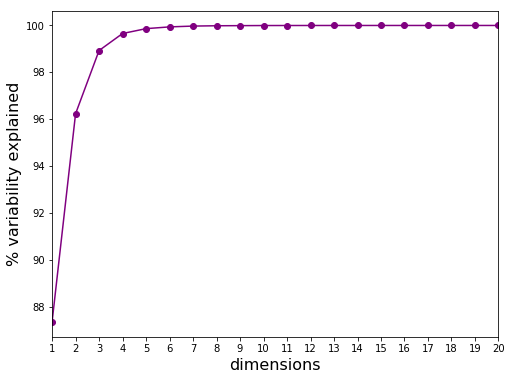

In [10]:
plt.figure(figsize=(8,6))
plt.plot(dimensions,cumulative_EV,color="purple",marker='o')
plt.xlabel("dimensions",fontsize=16)
plt.ylabel("% variability explained",fontsize=16)
plt.xlim(1,max_components)
plt.xticks(np.arange(max_components)+1)
# plt.savefig('pca.png',dpi=300,bbox_inches='tight')
plt.show()

### Create table of variance explained per dimension

In [11]:
table = pd.DataFrame({'dimensions': dimensions,
                      '% variance explained': explained_var, 
                   'cumulative % variance explained': cumulative_EV})

In [12]:
table.head(7)

,dimensions,% variance explained,cumulative % variance explained
0,1,87.354740,87.354740
1,2,8.880521,96.235262
2,3,2.695222,98.930484
3,4,0.726314,99.656797
4,5,0.207270,99.864067
5,6,0.075062,99.939129
6,7,0.034612,99.973741


## Reduce number of features using PCA

In [13]:
#set n_components=2 to denote reduction of data to 2 dimensions
pca = PCA(n_components=2, svd_solver='full')
y = pca.fit(cum_votes)
components_after_pca = y.components_
reduced_features = y.transform(cum_votes)
cov_mat = y.get_covariance()

## Plot new features

In [15]:
def archetype_plots(arc_senators):    
    normalization = []

    for n in range(arc_senators.shape[0]):
        sorted_arc = arc_senators[n]
        
        peak = max(sorted_arc)
        mean = np.mean(sorted_arc)
        sigma = np.std(sorted_arc)
        
        plt.figure(figsize=(8.5,6))
        
        plt.bar(np.arange(len(arc_senators.T)),sorted_arc/peak)
        plt.axhline((mean+sigma)/peak,color='black',linestyle='--',label='$\mu + \sigma$')
        plt.xticks(np.arange(0,len(arc_senators.T)+1,5))
        plt.xlabel('candidate',fontsize=14)
        plt.ylabel('amplitude',fontsize=14)
        plt.grid(b=True,axis='both')
        plt.margins(0.03)
        plt.legend(loc='lower right')
        plt.title('2013 PC'+str(n+1),fontsize=16)
        
#         plt.savefig('2013_PC'+str(n+1)+'.png',dpi=300,bbox_inches='tight')
        plt.show()

        normalization.append(peak)
        
    return normalization

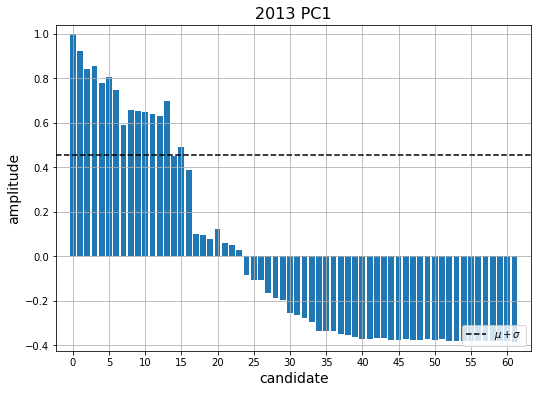

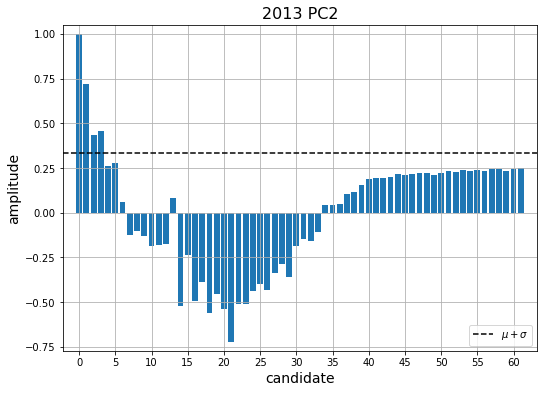

In [16]:
normalization = archetype_plots(reduced_features.T)

# K-means Clustering

## Apply elbow method to determine number of clusters

In [18]:
def elbow_method(cum_votes): # calculate distortion for a range of number of cluster
    distortions = []
    
    #use kmeans on cumulative votes for K=1 to K=15
    for i in range(1, 15):
        #use kmeans function from scikit
        kmeans = KMeans(
            n_clusters=i, init='random',
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0
        )
        kmeans.fit(cum_votes)
        
        #calculate mean squared error for each K
        distortions.append(kmeans.inertia_)

    # plot distortion vs K
    plt.figure(figsize=(8,6))
    plt.plot(range(1, 15), distortions, marker='o')
    plt.xlabel('Number of clusters',fontsize=18)
    plt.ylabel('Distortion',fontsize=18)
#     plt.savefig('elbow_2013_kmeans.png',bbox_inches='tight',dpi=600)
    plt.show()

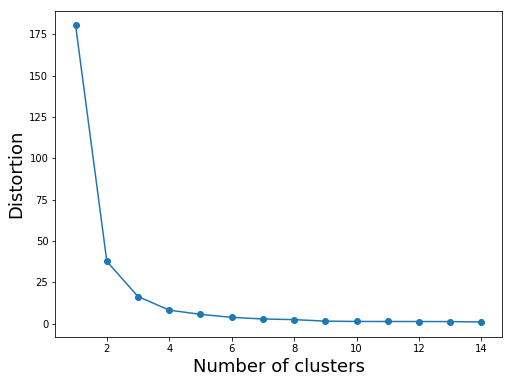

In [19]:
#apply elbow method on the reduced features
elbow_method(reduced_features)

## Silhouette Analysis

In [20]:
#perform silhouette analysis for K=2 to K=5 where the elbow looks to be around
range_n_clusters = [2, 3, 4, 5]


 For n_clusters = 2 The average silhouette_score is : 0.7065074474797002
Number of samples with silhouette greater than or equal to average : 43 / 62
Index of samples with negative silhouettes : []

 For n_clusters = 3 The average silhouette_score is : 0.664048635026242
Number of samples with silhouette greater than or equal to average : 34 / 62
Index of samples with negative silhouettes : []

 For n_clusters = 4 The average silhouette_score is : 0.6501376007916526
Number of samples with silhouette greater than or equal to average : 37 / 62
Index of samples with negative silhouettes : []

 For n_clusters = 5 The average silhouette_score is : 0.6383760243931426
Number of samples with silhouette greater than or equal to average : 37 / 62
Index of samples with negative silhouettes : []


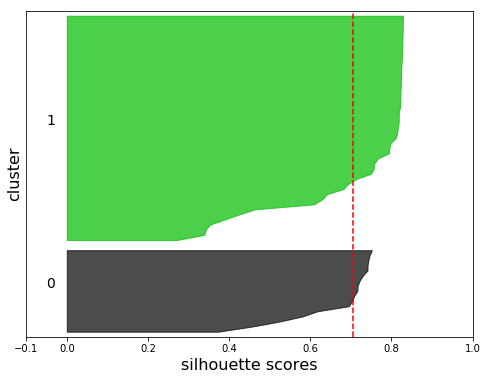

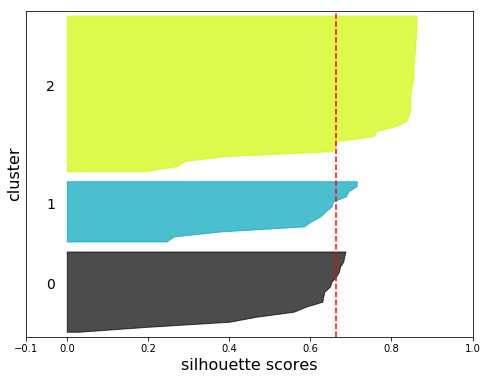

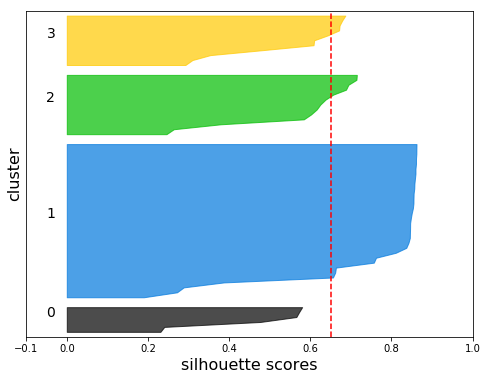

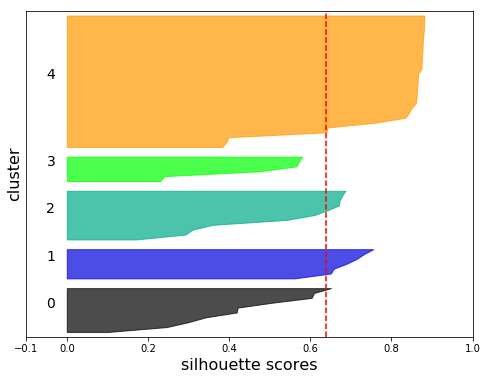

In [21]:
for n in range_n_clusters:
    
    #same parameters as the elbow method
    clusterer = KMeans(n_clusters=n, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0)
    cluster_labels = clusterer.fit_predict(cum_votes)

    #compute the average silhouette score
    silhouette_avg = silhouette_score(cum_votes, cluster_labels)
    
    #compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(cum_votes, cluster_labels)
    
    print("\n For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)
    print("Number of samples with silhouette greater than or equal to average :", 
          len(sample_silhouette_values[sample_silhouette_values>silhouette_avg]),"/",len(sample_silhouette_values))
    print("Index of samples with negative silhouettes :", np.where(sample_silhouette_values<0)[0])

    y_lower = 1
    
    plt.figure(figsize=(8,6))
    
    for i in range(n):
        #group silhoutte scores per cluster
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        #sort silhouette scores
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        #fill the silhouette plots with color
        color = cm.nipy_spectral(float(i) / n)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        #label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),fontsize=14)

        #compute the new y_lower for next plot
        y_lower = y_upper + 1  
    
    plt.xlabel("silhouette scores",fontsize=16)
    plt.ylabel("cluster",fontsize=16)

    #plot average silhouette score of all samples
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.ylim(0,len(cum_votes)+n)
    
#     plt.savefig('2019_silhouette_'+str(n)+'.png',dpi=300,bbox_inches='tight')

## K-means clustering

In [22]:
def kmeans(cluster_num,cum_votes):
    
    kmeans = KMeans(
    n_clusters=cluster_num, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0)
    
    cluster_labels = kmeans.fit_predict(cum_votes) #cluster labels per candidate
    
    return cluster_labels

## Apply K-means clustering to cumulative votes with reduced features

In [41]:
#set K=2
overall_labels = kmeans(5,reduced_features)

In [25]:
overall_labels[16] = 0
silhouette_avg = silhouette_score(reduced_features, overall_labels)
print('After reclassifying sample with negative silhouette, new average is: ',silhouette_avg)

After reclassifying sample with negative silhouette, new average is:  0.7331000496437877


## Create dataframe of cluster labels

In [42]:
overall_df = pd.DataFrame({'candidate': candidates,
                   'overall cluster': overall_labels+1})

In [43]:
overall_df

,candidate,overall cluster
0,Villar,1
1,Poe,1
2,Go,1
3,Cayetano,1
4,Dela Rosa,1
5,Angara,1
6,Lapid,5
7,Marcos,5
8,Tolentino,5
9,Pimentel,5


In [30]:
# overall_df.to_csv ('2019_clusters.csv', index = False, header=True)

## 2D Plot of Clusters

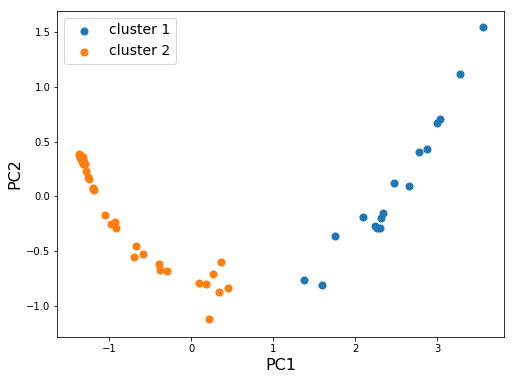

In [39]:
plt.figure(figsize=(8,6))

for j in range(max(overall_labels)+1):
    index = np.where(overall_labels==j)[0]
    cluster = reduced_features[index]
    
    xx = cluster.T[0] #set x-values as PC1
    yy = cluster.T[1] #set y-values as PC2
    
    plt.scatter(xx , yy, label='cluster '+str(j+1), marker='o',s=50)
    
plt.xlabel('PC1',fontsize=16)
plt.ylabel('PC2',fontsize=16)

plt.legend(fontsize=14)
# plt.savefig('2019_clusters.png',dpi=600,bbox_inches='tight')
plt.show()